The purpose of this model is to serve as a "naive" predictor, predicting the current value of glucose for 30 minutes out. This model is meant to serve as a baseline "no information" prediction. 

As the data is highly serially correlated, we can assume this prediction will actually be pretty good. 

In [ ]:
!pip install pyyaml==5.4.1
!pip install matplotlib==3.1.3
!pip install darts

In [ ]:
import time
import random
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import cpu_count, Pool # for prophet
from itertools import product
import os
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy.signal import lombscargle, periodogram
import darts
from darts import TimeSeries
from darts.models import AutoARIMA
from darts.metrics import mape
from darts.utils.statistics import plot_acf, extract_trend_and_seasonality, plot_hist, check_seasonality
from statsmodels.tsa.ar_model import AutoReg
import torch
import statistics
%matplotlib inline

### Sampling Rate
The problem: 
As can be seen above there are gaps in patient cgm data. This could be because a CGM was disconected or for some other reason. Additionally, the data is close to being sampled at 5 minutes for every sample, but as can be seen in the following plot, there are definitely times when the sample rate for the data is not normalized or constant. 

Solution: 
1. First, Find the longest Contiguous chunk of samples, per patient, for  which all samples are closer than 1.5 hours together in time. 

2. Second, re-sample the data at 30 minute intervals, performing a spline interpolation where necessary. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# helper functions
patient_ids = [183, 184,  14, 220, 233,  62,  17, 186,  52, 216, 115,  37, 244,
       167, 265,  81, 113, 248,  76,  21,  79, 132, 215, 223, 110,  19,
       260, 289,  54,  64, 232, 172,  45, 203, 119,  31,  24, 156, 276,
       162, 240, 239,  32, 236,  73,  26, 205,  48, 267,   2, 256, 141,
         8,  22, 204, 163,  42, 226, 251, 198, 165,  60, 264, 241, 138,
        67,  90, 206,  38, 266, 281,  10,  41, 185,  35, 140, 283, 118,
        80, 123, 217,  39, 160, 112,  50, 292, 164, 246,  18, 128, 103,
       210,   9,  71, 169,  65, 166,  74,  96, 134, 271,  55, 228, 234,
       155, 139,  95,   7,  11,  61, 250, 168, 108, 252, 106,  68, 213,
       127,  36, 176, 273, 130, 136, 152,  53, 193, 243, 253, 148, 135,
       274, 287, 231, 105, 201,   3, 200, 245,  91,  98, 101, 137,  70,
       219, 121, 143,  23, 109, 263,  46, 229,  93, 188,  72, 190, 211,
       218,  77, 181, 288, 278,  87, 173,  47,  33, 277, 224,  43, 257,
        69, 175,  58, 124,  78, 116, 146,  49,  30,  16,  86,   5, 158,
       171, 179, 258, 284, 170, 147, 249,  97, 131, 272, 285, 174, 222,
       102, 221,  15,  89,  57,  82,  29, 214, 149, 227,  20, 280, 247,
       269, 157,  40, 293, 145, 197,  27, 187, 254, 235, 209, 129, 177,
       291, 189, 290, 275, 111]
def downcast_to_float_32(df):
    df['GlucoseValue'] = df['GlucoseValue'].astype(np.float32)
    df['TotalDeviceMinutes'] = df['TotalDeviceMinutes'].astype(np.float32)
    df['TotalInternalHours_Diff'] = df['TotalInternalHours_Diff'].astype(np.float32)
    return df

def get_all_resampled_patient_timeseries(patient_dfs, value_column = "GlucoseValue"):
  all_patient_timeseries = []
  for df in patient_dfs: 
    individual_patient_timeseries = TimeSeries.from_dataframe(df, value_cols = [value_column]) 
    all_patient_timeseries.append(individual_patient_timeseries)
  return all_patient_timeseries

def get_resampled_patient_dfs(): 
  resampled_patient_dfs = []
  for patient_id in patient_ids:
    # patient_ids less than ten lead with 0, eg: 01
    patient_id_string = f'0{patient_id}' if patient_id < 10 else str(patient_id)
    df = pd.read_hdf(f'/content/drive/MyDrive/Colab Notebooks/data/resampled/patient_df_{patient_id_string}.h5')  
    df = downcast_to_float_32(df)
    resampled_patient_dfs.append(df)
  return resampled_patient_dfs

def plot_forecast(series_train, series_forecast, mape, ax):
  series_train.plot(label="actual", ax=ax)
  series_forecast.plot(label="forecast", ax=ax)
  plt.legend()
  print("MAPE = {:.2f}%".format(mape))

def get_rolling_30min_prediction(test_timeseries, model): 
  # give ourselves a large birth incase we have seasonality with a high value of s
  input_chunk_length = 50 
  last_predictable_timestep = len(resampled_patient_timeseries_train[0]) - input_chunk_length - 1
  prediction_range = range(input_chunk_length+1, last_predictable_timestep, 1)
  predictions = []
  for prediction_window_end_index in prediction_range: 
    print(f"start index = {prediction_window_end_index-input_chunk_length}")
    print(f"stop index = {prediction_window_end_index}")
    prediction_timesereies_window = test_timeseries[prediction_window_end_index-input_chunk_length:prediction_window_end_index]
    prediction = model.predict(n=1, series=prediction_timesereies_window, verbose=False, n_jobs=8)
    predictions.append(prediction)
  return predictions, test_timeseries[input_chunk_length+1:last_predictable_timestep]

In [ ]:
# resampled data 
resampled_patient_dfs = get_resampled_patient_dfs()
# use 50/50 for test/train for now
train_cutoff_index = round(len(resampled_patient_dfs)/2)

# dfs
resampled_patient_dfs_train = resampled_patient_dfs[:train_cutoff_index]
resampled_patient_dfs_test = resampled_patient_dfs[train_cutoff_index:]

# time-series
resampled_patient_timeseries_train = get_all_resampled_patient_timeseries(resampled_patient_dfs_train, "GlucoseValue")
resampled_patient_timeseries_test = get_all_resampled_patient_timeseries(resampled_patient_dfs_test, "GlucoseValue")

In [ ]:
# last value prediction mape
all_mapes = []
for individual_patient_timeseries_train in resampled_patient_timeseries_train: 
  current_mape = mape(individual_patient_timeseries_train.shift(n=1), individual_patient_timeseries_train)
  all_mapes.append(current_mape)

print(f"average mape was: {statistics.mean(all_mapes)}%")

average mape was: 12.093811755818603%


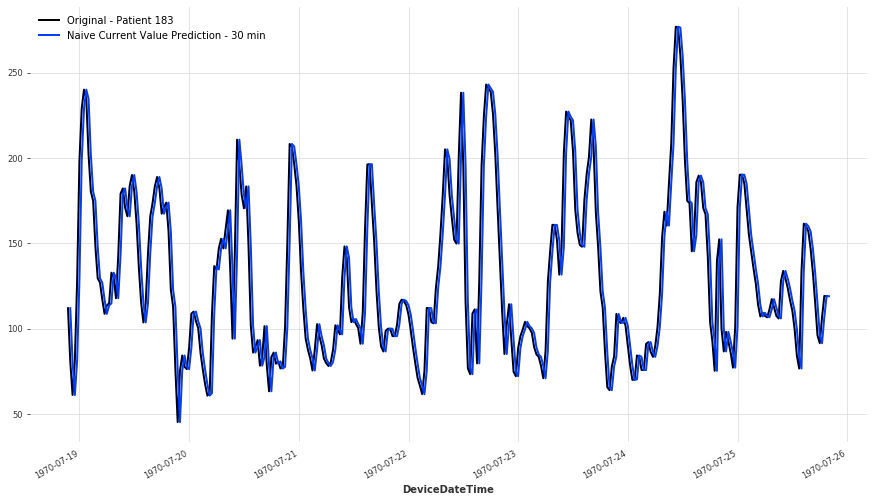

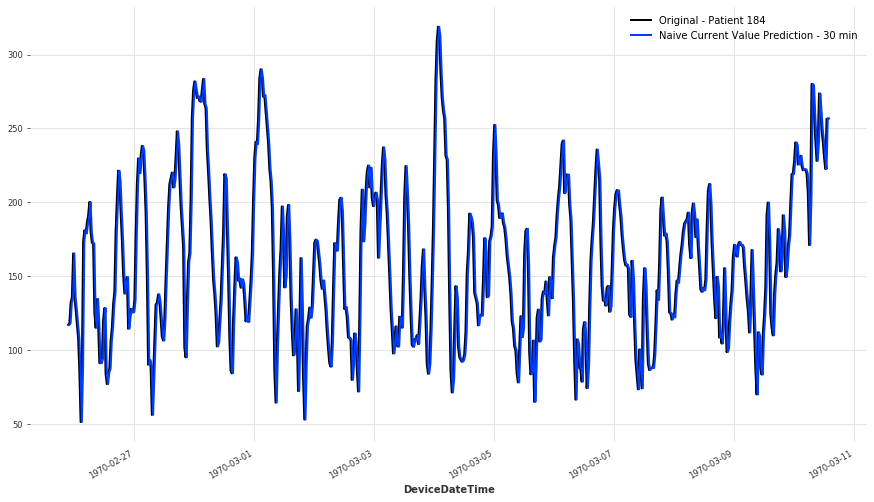

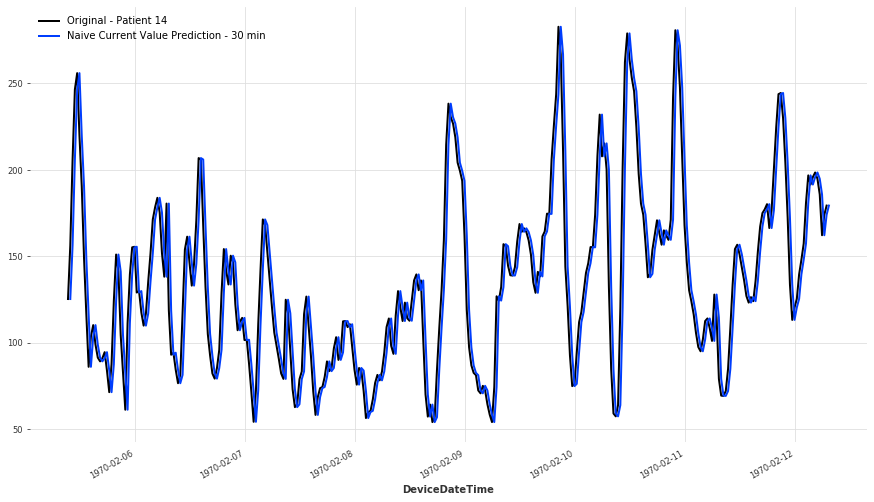

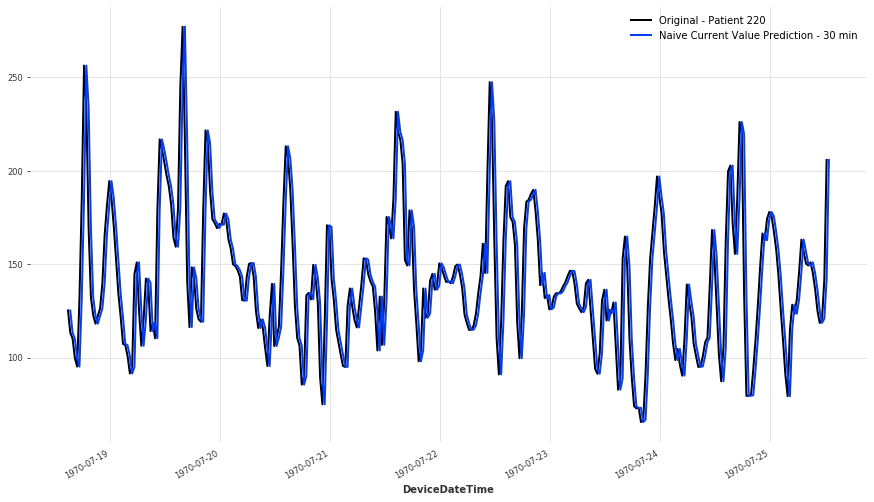

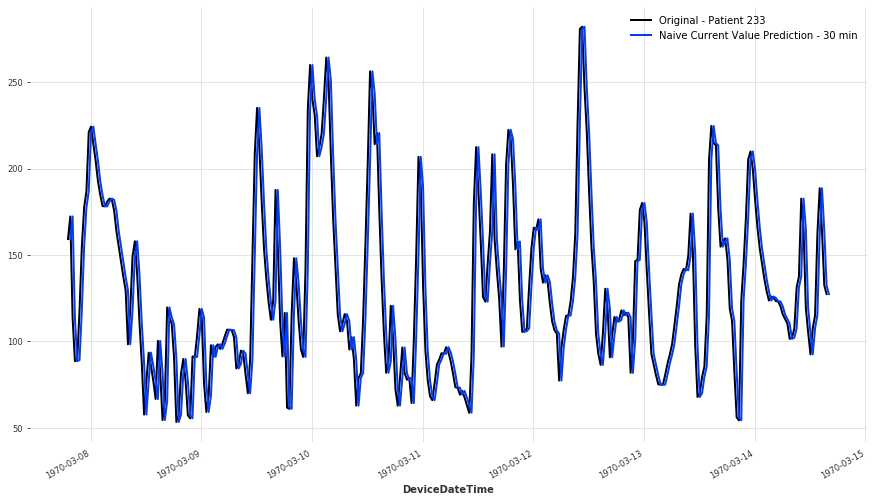

In [ ]:
# Train Historical Prediction plot
index = 0 
for patient_id_index in range(0, 5):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_train[patient_id_index].plot(label=f"Original - Patient {patient_ids[patient_id_index]}")
  resampled_patient_timeseries_train[patient_id_index].shift(n=1).plot(label="Naive Current Value Prediction - 30 min")

As can be seen above, the Naive 30 min prediction of glucose value, by simply predicting the it be the current value, has a fairly good mean absolute percentage error at 12.093811755818603%. It also requires NO training of ANY model. This will probably be hard to beat for many algorithms and serves as a strong "no information" prediction. This makes sense, because we have decently high positive correlation between our data for lags of 30min or even 1hr. 